In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

train = pd.read_csv ('data_titanic/titanic_train_wrangled.csv')
test = pd.read_csv ('data_titanic/titanic_test_wrangled.csv')

In [3]:
# remove unused columns
exclude = ['passengerid', 'survived']
feature_candidates = train.drop (columns=exclude)
feature_names = list (feature_candidates.columns)

In [ ]:
# View correlations
import seaborn as sns
correlations = train.corr()
sns.heatmap(correlations)
plt.show()

In [4]:
# which features are the most useful
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression ()
lr.fit (feature_candidates, train['survived'])
lr.coef_[0]
corr = pd.Series (lr.coef_[0], index=feature_names)
corr_sorted = corr.abs().sort_values(ascending=False)
feature_names_final = list(corr_sorted.index)[:38]
train_x = train[feature_names_final]
train_y = train['survived']

In [5]:
list(corr_sorted.index)[:38]

['title_mr',
 'title_master',
 'sex_female',
 'age_cat_child',
 'pclass_3',
 'family_1',
 'family_3',
 'title_mrs',
 'pclass_1',
 'cabin_type_n',
 'family_6',
 'cabin_type_e',
 'family_5',
 'sex_male',
 'age_cat_adult',
 'fare_cat_50-100',
 'pclass_2',
 'family_4',
 'embarked_c',
 'cabin_type_d',
 'title_officer',
 'family_11',
 'embarked_s',
 'age_cat_senior',
 'family_2',
 'fare_cat_missing',
 'age_cat_young_adult',
 'embarked_q',
 'family_8',
 'fare_cat_0-12',
 'cabin_type_c',
 'fare_cat_12-50',
 'cabin_type_f',
 'family_7',
 'cabin_type_b',
 'cabin_type_g',
 'title_royalty_male',
 'fare_cat_100+']

In [4]:
# Scale all features
# from sklearn.preprocessing import StandardScaler
# def scale_features (df):
#     scaler = StandardScaler()
#     scaler.fit(df)
#     return scaler.transform (df)

In [5]:
# Only if you want to scale the features. Since we converted all to dummies no need
# train_x = scale_features (train_x)

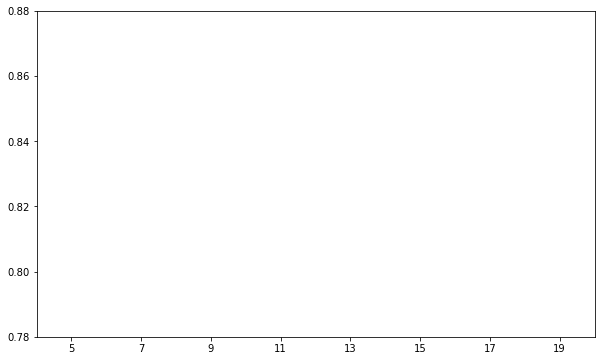

In [9]:
"""
    Linear Regression
"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model_scores = {}
for val in range(5,20,2):
    lr = LogisticRegression()
    accuracy = cross_val_score (lr, train_x, train_y, cv=val)
    model_scores[val] = accuracy.mean()

pd.Series(model_scores).plot.bar(figsize=(10,6), ylim=(0.78,0.88), color=list('rgbkymc'), rot=0)

In [ ]:
max (model_scores.values())

In [6]:
lr = LogisticRegression()
lr.fit (train_x, train_y)
print (lr.score (train_x, train_y))

0.8406285072951739


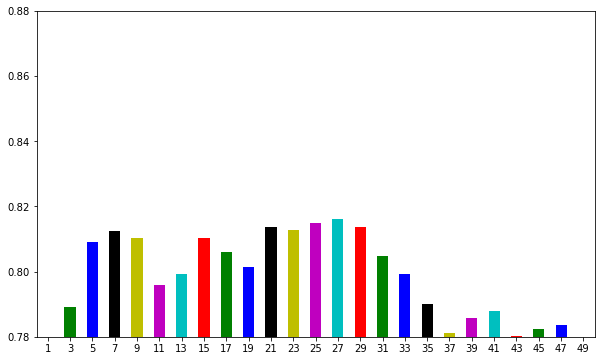

In [20]:
"""
    K-Nearest Neighbors
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

model_scores = {}
for val in range(1,50,2):
    knn = KNeighborsClassifier (n_neighbors=val)
    accuracy = cross_val_score (knn, train_x, train_y, cv=10)
    model_scores[val] = accuracy.mean()


pd.Series(model_scores).plot.bar(figsize=(10,6), ylim=(0.78,0.88), color=list('rgbkymc'), rot=0)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit (train_x, train_y)
print (knn.score (train_x, train_y))

0.8574635241301908


In [8]:
"""
    Try a grid search
"""
from sklearn.model_selection import GridSearchCV
hyperparameters = {
    "n_neighbors": range(1,50,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier ()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)
grid.fit (train_x, train_y)
best_params = grid.best_params_
best_score = grid.best_score_
print (best_score)

0.8226966292134833


In [58]:
"""
    now a randomforest
"""
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state=4, n_estimators=20, warm_start=True, max_depth=3, min_samples_leaf=2, max_features='sqrt')
rf.fit (train_x, train_y)
print (rf.score (train_x, train_y))

0.8114478114478114


In [56]:
"""
    this is new. give it a go
"""
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_x,train_y, early_stopping_rounds=1, eval_set=[(train_x, train_y)], 
            verbose=False)
print(xgb.score(train_x, train_y))

0.8608305274971941


In [62]:
# generate predictions
test_x = test[feature_names_final]
test_y = xgb.predict(test_x)

In [13]:
# generate predictions scaled
test_x = scale_features (test[feature_names_final])
test_y = knn.predict(test_x)

In [63]:
# just ml predictions
test_final = pd.DataFrame()
test_final['PassengerId'] = test['passengerid']
test_final['Survived'] = test_y.astype(int)

In [13]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [27]:
# combine programmatic with ml predictions
def apply_ml (row):
    if row['forecasted']:
        return row['pg_prediction']
    else:
        return row['ml_prediction']

df = pd.DataFrame()
df['pg_prediction'] = test['survived']
df['forecasted'] = test['forecasted']
df['ml_prediction'] = test_y.astype(int)

final_predictions = df.apply(apply_ml, axis=1)
test_final = pd.DataFrame()
test_final['PassengerId'] = test['passengerid']
test_final['Survived'] = final_predictions.astype(int)

In [14]:
# just programmatic
test_final = pd.DataFrame()
test_final['PassengerId'] = test['passengerid']
test_final['Survived'] = test['survived'].astype(int)

In [64]:
# Create the Kaggle submission file
test_final.to_csv ('data_titanic/submission_ml.csv', index=False)

In [13]:
test_final['Survived'].value_counts()

0    259
1    159
Name: Survived, dtype: int64